## BBM 409 - Programming Assignment 4

* You can add as many cells as you want in-between each question.
* Please add comments to your code to explain your work.  
* Please add Markdown cells to answer the (non-coding) questions in the homework text. You can, however, refer to the outputs of code cells without adding them as images to the Markdown cell unless you are requested to do otherwise.
* Please be careful about the order of runs of cells. Doing the homework, it is likely that you will be running the cells in different orders, however, they will be evaluated in the order they appear. Hence, please try running the cells in this order before submission to make sure they work.    
* Please refer to the homework text for any implementation detail. Though you are somewhat expected to abide by the comments in the below cells, they are mainly just provided for guidance. That is, as long as you are not completely off this structure and your work pattern is understandable and traceable, it is fine. For instance, you do not have to implement a particular function within a cell just because the comment directs you to do so.
* This document is also your report. Show your work.

### Name Surname : Ezgi Ekin
### Student ID : 2210356029


## Understanding LSTM's with Sentiment Analysis (100 points)

### 1. Data Loading and Exploration (5 points)
* Brief overview of the task :
* The task involves implementing a Long Short-Term Memory network from scratch for sentiment analysis using the PyTorch framework. The objective is to classify movie reviews as positive or negative. The implementation requires constructing the LSTM architecture with components such as embedding layers, LSTM layers, and fully connected layers. Additionally, the assignment covers data preprocessing, visualization of word embeddings.
* Description of the dataset used for analysis :
* The dataset used in this project is a subset of the IMDB Movie Reviews Dataset, a popular benchmark for sentiment analysis tasks. It includes 10,000 movie reviews, evenly split between positive and negative sentiments. The dataset comes in CSV format and needs some preprocessing before use. This includes cleaning the text, tokenizing it into words, and converting the words into numerical representations using Word2Vec embeddings. For training the model, the data will be divided into three parts: 70% for training, 20% for validation, and 10% for testing.

In [ ]:
pip install contractions

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import spacy
from tqdm import tqdm
import re
import contractions

In [ ]:
# Load the data into pandas a dataframe
# Represent the sentiments in a meaningful numerical form
# Check the first few rows
df = pd.read_csv('subset10000_IMDB_Dataset.csv')

status_mapping = {
    'negative': 0,
    'positive': 1
}

df['sentiment'] = df['sentiment'].map(status_mapping)


df.head()

,review,sentiment
0,"Starts really well, nice intro and build up fo...",0
1,"Terrific movie: If you did not watch yet, you ...",1
2,I've seen hundreds of silent movies. Some will...,1
3,i had been looking for this film for so long b...,1
4,"Good: Engaging cinematic firefights, great pre...",1


In [ ]:
## Explore the dataset (e.g., size, features, target variables, summary statistics).
## Check for any missing values and handle them if necessary.
print(f"Dataset Shape: {df.shape}")
print("-------------------")
print("Columns in the Dataset:")
print(df.columns)
print("-------------------")
print("Summary Statistics:")
print(df.describe())
print("-------------------")
print("Dataset Information:")
print(df.info())
print("-------------------")
print("Missing Values in Each Column:")
print(df.isnull().sum())

Dataset Shape: (10000, 2)
-------------------
Columns in the Dataset:
Index(['review', 'sentiment'], dtype='object')
-------------------
Summary Statistics:
          sentiment
count  10000.000000
mean       0.500000
std        0.500025
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
-------------------
Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     10000 non-null  object
 1   sentiment  10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB
None
-------------------
Missing Values in Each Column:
review       0
sentiment    0
dtype: int64


### 2. Preprocessing the Data (10 points)

In [ ]:
# An example function for prepocess the texts and create the tokens, you can improve it to clean the texts more accurately
# Ensure GPU usage if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
spacy.require_gpu()  # Enable GPU for spaCy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])  # Disable unused pipelines for efficiency

# Text preprocessing function
def preprocess_text(text):

    text = contractions.fix(text)
    text = re.sub(r'[/\|,\-]', ' ', text)           # Replace certain characters with spaces
    text = re.sub(r'<.*?>', ' ', text)              # Remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)     # Remove special characters
    text = text.lower()                             # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()        # Remove extra spaces

    # Tokenize, lemmatize, and filter stopwords/punctuation
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return tokens

In [ ]:
# Add a tokens column to the dataframe to store preprocessed tokens
# Add a "Tokens" column with preprocessed tokens
tqdm.pandas()  # Add progress bar
df['Tokens'] = df['review'].progress_apply(preprocess_text)
print(df.head())


100%|██████████| 10000/10000 [02:42<00:00, 61.53it/s]

                                              review  sentiment  \
0  Starts really well, nice intro and build up fo...          0   
1  Terrific movie: If you did not watch yet, you ...          1   
2  I've seen hundreds of silent movies. Some will...          1   
3  i had been looking for this film for so long b...          1   
4  Good: Engaging cinematic firefights, great pre...          1   

                                              Tokens  
0  [start, nice, intro, build, main, character, 5...  
1  [terrific, movie, watch, watch, geena, davis, ...  
2  [see, hundred, silent, movie, classic, nosfera...  
3  [look, film, long, find, see, young, love, sec...  
4  [good, engage, cinematic, firefight, great, pr...  


In [ ]:
# Build the vocabulary using the tokens
from collections import Counter
def build_vocab(tokens_list, min_freq=1):

    # Flatten the list of tokens # makes one big list of all tokens
    all_tokens = [token for tokens in tokens_list for token in tokens]

    # Count the frequency of each token # counts how often each word appears
    token_counts = Counter(all_tokens)

    # Build the vocabulary, filtering tokens below min_freq # makes the vocab, ignores rare words
    vocab = {'<PAD>': 0}  # Reserve 0 for padding # padding is at index 0
    for idx, (token, count) in enumerate(token_counts.items(), start=1): # start from 1 so padding is 0
        if count >= min_freq: # only add if it appears enough times
            vocab[token] = idx

    return vocab

tokens_list = df['Tokens'].tolist() # get the tokens from the dataframe
vocab = build_vocab(tokens_list, min_freq=1) # build the vocab

# Assign indices to each token in the vocabulary
def tokens_to_indices(tokens, vocab):

    return [vocab.get(token, 0) for token in tokens] # gets the index, 0 if not in vocab (for padding)


# Add token indices column to the DataFrame # adds a new column with the indices
df['Token_Indices'] = df['Tokens'].apply(lambda tokens: tokens_to_indices(tokens, vocab))
# Reserve 0 for padding
df[['Tokens', 'Token_Indices']] # shows the tokens and their indices

,Tokens,Token_Indices
0,"[start, nice, intro, build, main, character, 5...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 6, 11, 5, 12, ..."
1,"[terrific, movie, watch, watch, geena, davis, ...","[62, 20, 55, 55, 63, 64, 65, 66, 67, 68, 20, 6..."
2,"[see, hundred, silent, movie, classic, nosfera...","[81, 82, 83, 20, 84, 85, 86, 87, 88, 89, 90, 3..."
3,"[look, film, long, find, see, young, love, sec...","[93, 90, 75, 122, 81, 123, 124, 125, 126, 124,..."
4,"[good, engage, cinematic, firefight, great, pr...","[33, 166, 167, 168, 69, 169, 170, 171, 172, 17..."
...,...,...
9995,"[fool, go, start, review, say, movie, remind, ...","[6434, 179, 1, 365, 1033, 20, 2716, 4113, 2009..."
9996,"[feel, duty, lover, horror, film, warm, people...","[56, 6369, 1101, 358, 90, 3845, 300, 1031, 180..."
9997,"[film, creator, thinking, 8, mm, film, plot, s...","[90, 3968, 5164, 1009, 6169, 90, 35, 622, 3911..."
9998,"[true, sadomasochism, sided, coin, contain, di...","[924, 42304, 17456, 9932, 1483, 3897, 3725, 32..."


In [ ]:
print(df.iloc[9998]["review"])
print("********")
print(df.iloc[9998]["Tokens"])


If it is true that sadomasochism is a two-sided coin which contains the whole in the diverse expression of its opposites, then the cinematic portrait of Erika Kohut has its reality. Professor Kohut treats her piano students with a kind of fascist sadism while longing for the same for herself. Her outward expression projects her desire. That is why she can hurt without guilt or remorse.<br /><br />Along comes talented, charming, handsome young Walter Klemmer (Benoit Magimel) who is attracted to her because of her passion and her intensity. He wants to become her student so as to be close to her. She rejects him out of hand, but because of his talent the Vienna conservatory votes him in. He falls in love with her. Again she pushes him away, but he will not take no for an answer, and thereby begins his own descent into depravity and loss of self-respect.<br /><br />The question the viewer might ask at this point is, who is in control? The sadist or the masochist? Indeed who is the sadist 

In [ ]:
# Calculate the length of each review from the tokenized version
df['Review_Length'] = df['Tokens'].apply(len)
# Display statistical details about review lengths
review_lengths = df['Review_Length']
print("Statistical Details of Review Lengths:")
print(review_lengths.describe())
# Decide padding length considering these stats
# Remember we don't want padded zeros to overcome meaningful information in the sequence

Statistical Details of Review Lengths:
count    10000.000000
mean       105.213900
std         81.149369
min          4.000000
25%         55.000000
50%         78.000000
75%        129.000000
max        762.000000
Name: Review_Length, dtype: float64


In [ ]:
padding_length = 150  # Based on 75th percentile + buffer

I chose a padding length of 150 based on the 75th percentile of review lengths, which is 129 words, with an added buffer to account for slightly longer reviews. This ensures that the majority of reviews are fully captured without truncation while avoiding excessive padding that could make the model inefficient. Padding all reviews to the maximum length of 762 would introduce too many unnecessary zeros, increasing computational cost and the risk of overfitting. A length of 150 provides a balance between retaining enough content for meaningful analysis and maintaining computational efficiency.

In [ ]:
# Convert review tokens to indices and add an indices column to the dataframe to store
# Represent each token in the dataset with its corresponding index from the vocabulary
# Ensure all sequences have the same length by padding shorter sequences with zeros
# Pad the token indices version of review sequences

def pad_sequence(seq, max_len):

    if len(seq) > max_len:
        return seq[:max_len]  # Truncate longer sequences # cuts off if too long
    else:
        return [0] * (max_len - len(seq)) + seq  # Pre-pad shorter sequences # adds 0s to the start if too short

# Add an padded_indices column to store padded sequences
df['padded_indices'] = df['Token_Indices'].apply(lambda x: pad_sequence(x, padding_length)) # makes a new column with padded sequences
print(df['Token_Indices'].iloc[38]) # shows the original indices for row 38
print(df['padded_indices'].iloc[38]) # shows the padded indices for row 38

[1750, 90, 1751, 1752, 90, 1753, 1754, 527, 1755, 950, 1756, 20, 1757, 254, 1758, 517, 129, 1759, 1760, 61, 124, 1761, 1762, 167, 1763, 1541, 1764, 151, 333, 71, 1765, 6, 1468, 6, 821, 90, 1766, 1767, 1287, 492, 92, 1768, 1299, 6, 1541, 1769, 1770, 366, 500, 258, 331, 1771, 83, 1772, 205, 74, 961, 1298, 1340, 1773]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1750, 90, 1751, 1752, 90, 1753, 1754, 527, 1755, 950, 1756, 20, 1757, 254, 1758, 517, 129, 1759, 1760, 61, 124, 1761, 1762, 167, 1763, 1541, 1764, 151, 333, 71, 1765, 6, 1468, 6, 821, 90, 1766, 1767, 1287, 492, 92, 1768, 1299, 6, 1541, 1769, 1770, 366, 500, 258, 331, 1771, 83, 1772, 205, 74, 961, 1298, 1340, 1773]


LSTMs, process input sequences step by step. By padding at the front, the actual data remains at the later steps of the sequence. This ensures that the most meaningful parts of the sequence are processed closer to the final hidden states, which are often used for classification or prediction.

### 3. Visualzing Word Vectors (15 points)

In [ ]:
# Load the FastText word vectors
import gensim.downloader as api
fasttext_vectors = api.load("fasttext-wiki-news-subwords-300")
print("FastText model loaded.")

FastText model loaded.


In [ ]:
# Check out for Out-of-Vocaublary (OOV) words
def find_oov_words(vocab, fasttext_model):
    oov_words = []
    for word in vocab:
        if word != '<PAD>' and word not in fasttext_model:  # Exclude PAD token # skips the padding token
            oov_words.append(word) # adds words not in fasttext to oov list
    return oov_words
oov_words = find_oov_words(vocab, fasttext_vectors) # finds the oov words

# Print statistics
print(f"Total words in vocabulary: {len(vocab)}")
print(f"Number of OOV words: {len(oov_words)}")
print(f"Percentage of OOV words: {len(oov_words) / len(vocab) * 100:.2f}%") # percentage of oov words
print(f"Some OOV Words: {oov_words[:100]}")

# See how many words in your created vocaublary are not presented in fasttext-vectors
# Make comments on how OOV words can effect your model performance

Total words in vocabulary: 42315
Number of OOV words: 11395
Percentage of OOV words: 26.93%
Some OOV Words: ['geena', 'hearst', 'nightfire', 'dabney', 'crispin', 'bartleby', 'thurman', 'noirishness', 'universism', 'pablito', 'travolta', 'gilley', 'madolyn', 'fraiser', 'bredon', 'whalley', 'courtenay', 'zhivago', 'jessalyn', 'gilsig', 'andie', 'macdowell', 'imelda', 'staunton', 'phonus', 'bolognus', 'lillian', 'harron', 'elderbush', 'gluch', 'barrymore', 'ustinov', 'newhart', 'malden', 'tianaman', 'potempkin', 'grigory', 'vakulinchuk', 'aleksandr', 'antonov', 'eisenstein', 'rainn', 'legolas', 'lazenby', 'brosnan', 'niven', 'octopussy', 'moonraker', 'gerardo', 'jaffe', 'cianelli', 'kiple', 'gunga', 'ilene', 'tremain', 'goldthwaite', 'cusack', 'rko', 'charteris', 'fernack', 'guilfoyle', 'kilmer', 'azjazz', 'phillipine', 'duvall', 'coppolla', 'spaceball', 'elwe', 'aame', 'jerkingly', 'hooraye', 'sematary', 'gwyne', 'kolchak', 'vincenzo', 'fiedler', 'dehner', 'darden', 'mcgavin', 'grinnage'

OOV words are typically replaced with a placeholder token, which means the model loses the specific information those words carry. This can be particularly challenging if the OOV words include sentiment-rich expressions like "amazing" or "horrible," as these are essential for understanding sentiment. When there is a high percentage of OOV words, the model may have difficulty accurately interpreting the context of the input text. Additionally, if many words are replaced with \<PAD>, the embedding layer becomes less effective. Sentiment-rich words, such as specialized terms, idiomatic phrases, or informal expressions (e.g. "meh"), may go unrecognized, leading to an incomplete understanding of the review. As a result, the model becomes less capable of detecting subtle differences in tone or sentiment intensity.

In [ ]:
# Visualize word vectors to understand how they work.
# Start by choosing a manageable number of words from the vocabulary, ideally 100–500.
# Focus on words that are frequent in the dataset or relevant to the task,
# Such as sentiment-rich terms like "good," "bad," "amazing," or "terrible."
sentiments = [ # lists of positive, negative, and neutral words
    ["good", "amazing", "happy", "excellent", "great", "wonderful", "love",
     "fantastic", "awesome", "superb", "pleasant", "joyful", "delightful",
     "outstanding", "marvelous", "cheerful", "thrilling", "charming",
     "admirable", "graceful", "brilliant", "radiant", "optimistic",
     "vibrant", "heavenly", "terrific", "elegant", "harmonious", "peaceful",
     "triumphant", "uplifting", "blissful", "magnificent", "hopeful"],

    ["bad", "terrible", "sad", "hate", "horrible", "awful", "dreadful",
     "miserable", "disgusting", "atrocious", "disappointing", "sorrowful",
     "unpleasant", "pathetic", "tragic", "abysmal", "depressing", "wretched",
     "appalling", "disturbing", "hateful", "detestable", "nasty", "repulsive",
     "despicable", "inferior", "unbearable", "ghastly", "hideous", "loathsome",
     "regrettable", "shameful", "vile", "unpleasant", "lamentable", "horrid",
     "insufferable", "unforgivable", "disgraceful", "grim", "dire", "ominous"],

    ["okay", "fine", "fair", "mediocre", "average", "indifferent", "ordinary",
     "moderate", "neutral", "balanced", "adequate", "passable", "standard",
     "middling", "tolerable", "acceptable", "simple", "unassuming", "basic",
     "generic", "unremarkable", "regular", "routine", "plain", "average-looking",
     "undistinguished", "normal", "reasonable", "lukewarm", "sufficient",
     "stable", "unspectacular", "steady", "middle-of-the-road", "middle"]
]


selected_words = []
for lst in sentiments: # goes through each sentiment list
    count = 0
    for word in lst: # goes through each word in the sentiment list
        if word in vocab and word not in selected_words: # adds the word if it's in our vocab and not already selected
            selected_words.append(word)
            count += 1
        if word in fasttext_vectors: # if the word is in fasttext
            for word2 in fasttext_vectors.most_similar(word): # find similar words in fasttext
                if word2[0] in vocab and word2[0] not in selected_words: # add similar words if they are in our vocab and not already selected
                    selected_words.append(word2[0])
                    count += 1
                if count >= 100:  # Stop when 100 words are selected from the current list # gets up to 100 words per sentiment
                    break
        if count >= 100:  # Break the outer loop when 100 words are selected # makes sure we don't go over 100 per sentiment
            break

# Print the selected words
print(f"Selected {len(selected_words)} words:") # shows how many we selected
print(selected_words) # shows the selected words

Selected 301 words:
['good', 'bad', 'goood', 'excellent', 'decent', 'great', 'nice', 'amazing', 'incredible', 'awesome', 'unbelievable', 'wonderful', 'astounding', 'remarkable', 'fantastic', 'marvelous', 'fabulous', 'astonishing', 'happy', 'unhappy', 'glad', 'chappy', 'thankful', 'superb', 'excelent', 'excellant', 'terrific', 'outstanding', 'admirable', 'tremendous', 'greate', 'greatest', 'huge', 'enormous', 'lovely', 'wonderfull', 'delightful', 'marvellous', 'beautiful', 'love', 'hate', 'lover', 'loving', 'loved', 'fantastical', 'awesomely', 'awesomeness', 'brilliant', 'magnificent', 'splendid', 'pleasant', 'agreeable', 'unpleasant', 'pleasurable', 'enjoyable', 'pleasantly', 'joyful', 'joyous', 'cheerful', 'joy', 'sorrowful', 'exuberant', 'delicious', 'delightfully', 'charming', 'exceptional', 'outstandingly', 'extraordinary', 'exemplary', 'wondrous', 'cheery', 'jovial', 'upbeat', 'amiable', 'thrilling', 'exhilarating', 'exciting', 'enthralling', 'suspenseful', 'thrill', 'fascinating'

In [ ]:
fasttext_vectors.most_similar("act")

[('acts', 0.8020645976066589),
 ('re-act', 0.7534699440002441),
 ('acting', 0.7014284729957581),
 ('action', 0.6946718096733093),
 ('inact', 0.6897709965705872),
 ('acted', 0.6879609227180481),
 ('act-', 0.6839857697486877),
 ('re-action', 0.6699843406677246),
 ('actvity', 0.6694703102111816),
 ('counter-act', 0.6645603775978088)]

In [ ]:
# For the selected words, retrieve their corresponding vector representations from the the pre-trained Word2Vec model.
# Each word will have a dense vector of a fixed dimensionality (e.g., 300 for fasttext-wiki-news-subwords-300).
word_vectors = {}
for word in selected_words:
    if word in fasttext_vectors:
          word_vectors[word] = fasttext_vectors[word]
    else:
          print(f"Word '{word}' not found in the model's vocabulary.")

for word, vector in list(word_vectors.items())[:10]:
    print(f"Word: {word}")
    print(vector.shape) # the shape of the vector (should be 300)
    print(f"Vector: {vector[:10]}...")
    print()

Word: good
(300,)
Vector: [-0.0001702 -0.011244   0.0029221 -0.026231  -0.087082  -0.06542
 -0.04714   -0.12225    0.043872   0.013686 ]...

Word: bad
(300,)
Vector: [ 0.016392   0.051509   0.0034148 -0.0022261 -0.063852  -0.14773
  0.020737  -0.1235     0.073686   0.016608 ]...

Word: goood
(300,)
Vector: [-0.013283  -0.012549  -0.024145  -0.057874  -0.076466  -0.015793
 -0.0043217 -0.073314   0.032024   0.0047366]...

Word: excellent
(300,)
Vector: [-0.010257   -0.01271     0.031528   -0.00034434 -0.036504   -0.036151
 -0.033739   -0.10918    -0.030203    0.01885   ]...

Word: decent
(300,)
Vector: [ 0.017336  -0.040368   0.038755   0.010491  -0.027716   0.0095265
  0.018769  -0.10722    0.0072268  0.040508 ]...

Word: great
(300,)
Vector: [-0.0293    -0.070607   0.030162   0.011547  -0.089793  -0.0099507
 -0.049528  -0.10988    0.047705   0.042368 ]...

Word: nice
(300,)
Vector: [ 0.019588 -0.027946  0.046345 -0.030603 -0.090593  0.01164  -0.02061
 -0.13271  -0.075489  0.014737]...


In [ ]:
# Use Principal Component Analysis (PCA) to reduce the dimensionality of the word vectors from their original size (e.g., 300) to 2D or 3D.
# PCA simplifies the high-dimensional data while preserving as much variance as possible, making it easier to visualize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import gensim.downloader as api
words = list(word_vectors.keys())
vectors = list(word_vectors.values())
print(f"Reducing word vectors to {2} dimensions using PCA...")
pca_2D = PCA(n_components=2)
reduced_vectors_2D = pca_2D.fit_transform(vectors)
print("PCA completed!")
print(f"Reducing word vectors to {3} dimensions using PCA...")
pca_3D = PCA(n_components=3)
reduced_vectors_3D = pca_3D.fit_transform(vectors)
print("PCA completed!")

Reducing word vectors to 2 dimensions using PCA...
PCA completed!
Reducing word vectors to 3 dimensions using PCA...
PCA completed!


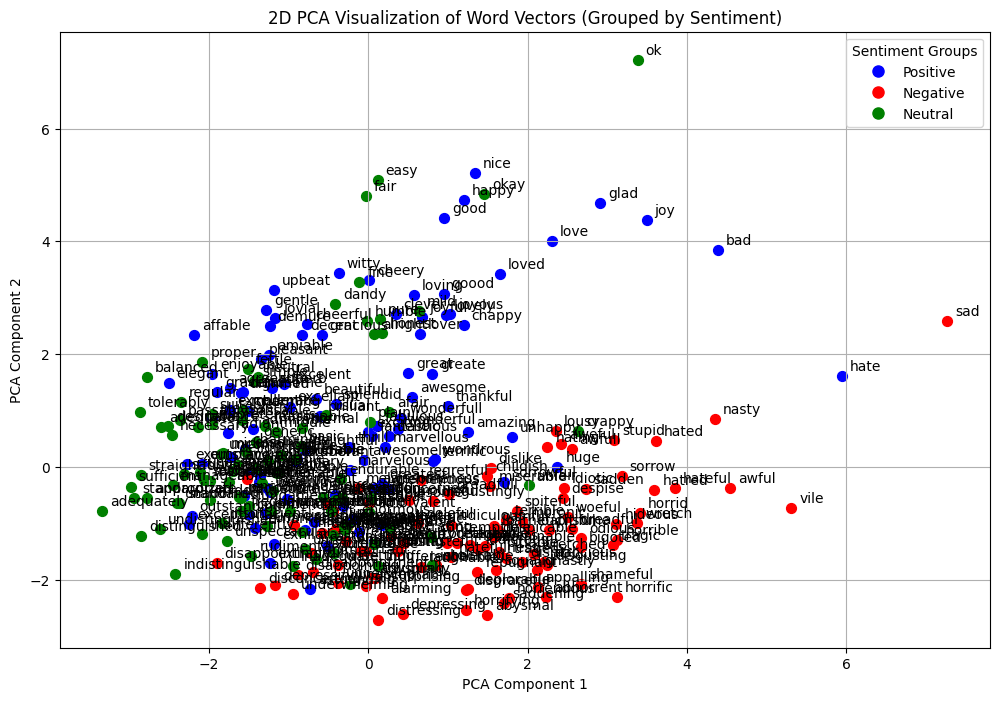

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Define group assignments based on indices
group_assignments = ["positive"] * 100 + ["negative"] * 100 + ["neutral"] * (len(words) - 200)

# Scale and add jitter to the coordinates
scale_factor = 10  # Increase separation between points
jitter = 0.5       # Add slight randomness to reduce overlap
scaled_vectors_2D = [[coord[0] * scale_factor + np.random.uniform(-jitter, jitter),
                      coord[1] * scale_factor + np.random.uniform(-jitter, jitter)]
                     for coord in reduced_vectors_2D]

# Define colors for each sentiment group
group_colors = {
    "positive": "blue",
    "negative": "red",
    "neutral": "green"
}

# 2D Scatter Plot
plt.figure(figsize=(12, 8))

# Scatter each group with consistent coloring
for word, coord, group in zip(words, scaled_vectors_2D, group_assignments):
    plt.scatter(coord[0], coord[1], color=group_colors[group], s=50, marker='o')
    plt.annotate(word, (coord[0] + 0.1, coord[1] + 0.1), fontsize=10)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=8, label=group.capitalize())
           for group, color in group_colors.items()]
plt.legend(handles=handles, title="Sentiment Groups", loc="upper right")

# Set plot details
plt.title("2D PCA Visualization of Word Vectors (Grouped by Sentiment)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


In [ ]:
import plotly.graph_objects as go
import numpy as np

# Assign groups: first 100 words are positive, next 100 are negative, the rest are neutral
group_assignments = ["positive"] * 100 + ["negative"] * 100 + ["neutral"] * (len(words) - 200)
# Define colors for each group
# Define colors for each group
group_colors = {
    "positive": "blue",
    "negative": "red",
    "neutral": "green"
}

# Scale and add jitter to the coordinates
scale_factor = 5
jitter = 0.1
scaled_vectors_3D = [[coord[0] * scale_factor + np.random.uniform(-jitter, jitter),
                      coord[1] * scale_factor + np.random.uniform(-jitter, jitter),
                      coord[2] * scale_factor + np.random.uniform(-jitter, jitter)]
                     for coord in reduced_vectors_3D]

# Group words and coordinates
grouped_data = {"positive": [], "negative": [], "neutral": []}
grouped_coords = {"positive": [], "negative": [], "neutral": []}

for word, coord, group in zip(words, scaled_vectors_3D, group_assignments):
    grouped_data[group].append(word)
    grouped_coords[group].append(coord)

# Create a Plotly Scatter3D object
fig = go.Figure()

# Add one trace per group
for group, color in group_colors.items():
    coords = np.array(grouped_coords[group])  # Convert to numpy array for indexing
    fig.add_trace(go.Scatter3d(
        x=coords[:, 0],  # X-axis
        y=coords[:, 1],  # Y-axis
        z=coords[:, 2],  # Z-axis
        mode='markers+text',  # Show markers and text labels
        marker=dict(
            size=4,  # Adjust marker size for clarity
            color=color,  # Group color
            opacity=0.8
        ),
        text=grouped_data[group],  # Word labels
        textposition='top center',
        name=group.capitalize()  # Group name for legend
    ))

# Set titles and axis labels
fig.update_layout(
    title="3D PCA Visualization of Word Vectors (Grouped by Sentiment)",
    scene=dict(
        xaxis_title="PCA Component 1",
        yaxis_title="PCA Component 2",
        zaxis_title="PCA Component 3"
    ),
    width=1000,
    height=800,
    legend=dict(title="Sentiment Groups")
)

# Show the interactive plot
fig.show()

In [ ]:
# Examine the resulting visualization for patterns.
# Look for clusters of similar words, such as synonyms or words with similar sentiment,
# Observe the distances between opposite terms.
# Demonstrate how word vectors capture semantic relationships.

In the visualizations, we can clearly see clusters of words with similar sentiments or meanings. For example, words like "joyful," "cheerful," and "happy" are grouped together, showing their shared positive sentiment. Similarly, negative words such as "horrible," "awful," and "vile" form another distinct cluster. Opposite terms like "love" and "hate" are positioned far apart in the embedding space, highlighting their contrasting sentiments. The separation of positive, negative, and neutral terms demonstrates that the word vectors successfully capture the polarity of sentiments. Words with slight semantic differences but similar contexts are also placed near each other, showing the model’s ability to understand subtle meanings. For instance, "affable" and "cheerful" are both positive words with different intensities but are close in context, so they appear close on the plot. Neutral words like "okay" and "fair" form a separate group, distinct from strongly positive or negative words.

### 4. Creating the Emebdding Matrix (10 points)

In [ ]:
def create_embedding_matrix(word2vec, vocab, embedding_dim):
    # Initialize the embedding matrix with zeros # makes a matrix full of zeros
    vocab_size = len(vocab)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))


    for word, idx in vocab.items():
        if word in word2vec:
            embedding_matrix[idx] = word2vec[word]
        else:
            # If the word is not in the pre-trained embeddings, use a random vector # if not found, uses a random vector
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return embedding_matrix

# Create a matrix where each row corresponds to the vector representation of a word in the vocabulary
# Step 3: Create the Embedding Matrix
embedding_dim = 300
embedding_matrix = create_embedding_matrix(fasttext_vectors, vocab, embedding_dim)
# The embedding matrix will have dimensions [vocab_size, embedding_dim], where embedding_dim is the size of the word vectors # it's vocab size by 300

In [ ]:
# Convert the embedding matrix to a PyTorch tensor
# You can create the embedding layer in here or directly in the model
# Using PyTorch’s nn.Embedding.from_pretrained method you load the pre-trained embedding matrix into the embedding layer
# Convert Embedding Matrix to a PyTorch Tensor
embedding_tensor = torch.tensor(embedding_matrix, dtype=torch.float32)


### 5. Implementing the IMDBDataset (5 points)
* Use PyTorch’s Dataset and DataLoader classes to manage the dataset efficiently and create mini-batches for training.

In [ ]:
# Train, validation and test split
from torch.utils.data import random_split

In [ ]:
# Implement the dataset class
class SentimentDataset(Dataset):
    def __init__(self, df):

        self.texts = [torch.tensor(indices, dtype=torch.long) for indices in df['padded_indices']] # makes tensors of the padded indices
        self.labels = torch.tensor(df['sentiment'].values, dtype=torch.float32) # makes tensors of the labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]
# Combine the padded sequences and corresponding sentiment labels into a dataset structure compatible with PyTorch.
def collate_fn(batch):

    texts, labels = zip(*batch) # separates texts and labels
    texts = torch.stack(texts)  # Combine sequences into a tensor # makes a batch of texts
    labels = torch.stack(labels)  # Combine labels into a tensor # makes a batch of labels
    return texts, labels

# Create Dataset
dataset = SentimentDataset(df)

# Dataset sizes
train_size = int(0.7 * len(dataset)) # 70% for training
val_size = int(0.2 * len(dataset)) # 20% for validation
test_size = len(dataset) - train_size - val_size # rest for testing

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
# Create the train, validation and test dataLoaders
# Define batch size
batch_size =32

# Create DataLoaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,  # Optimizes data transfer to GPU
    num_workers=4
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    num_workers=4
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    num_workers=4
)

# Verify DataLoader output
for batch_idx, (texts, labels) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Texts (padded):\n{texts}")
    print(f"Labels:\n{labels}")
    break  # Display only the first batch


Batch 1:
Texts (padded):
tensor([[    0,     0,     0,  ...,    46,    50,    55],
        [    0,     0,     0,  ...,   200,   487,  2931],
        [    0,     0,     0,  ...,  1047,    81,   180],
        ...,
        [ 1438,  1195, 24563,  ..., 11613,  2359,  1137],
        [    0,     0,     0,  ...,   135,  1447,    78],
        [    0,     0,     0,  ...,  1857,  1226,  1281]])
Labels:
tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0.])


### 6. Implementing and Optimizing the Custom LSTM model (40 points)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Define gates (weights and biases)
        self.W_ii = nn.Parameter(torch.Tensor(hidden_size, input_size)) #Input gate weights for input
        self.W_hi = nn.Parameter(torch.Tensor(hidden_size, hidden_size)) #Input gate weights for hidden
        self.b_i = nn.Parameter(torch.Tensor(hidden_size)) #Input gate bias

        self.W_if = nn.Parameter(torch.Tensor(hidden_size, input_size)) #Forget gate weights for input
        self.W_hf = nn.Parameter(torch.Tensor(hidden_size, hidden_size)) #Forget gate weights for hidden
        self.b_f = nn.Parameter(torch.Tensor(hidden_size)) #Forget gate bias

        self.W_ig = nn.Parameter(torch.Tensor(hidden_size, input_size)) #Cell gate weights for input
        self.W_hg = nn.Parameter(torch.Tensor(hidden_size, hidden_size)) #Cell gate weights for hidden
        self.b_g = nn.Parameter(torch.Tensor(hidden_size)) #Cell gate bias

        self.W_io = nn.Parameter(torch.Tensor(hidden_size, input_size)) #Output gate weights for input
        self.W_ho = nn.Parameter(torch.Tensor(hidden_size, hidden_size)) #Output gate weights for hidden
        self.b_o = nn.Parameter(torch.Tensor(hidden_size)) #Output gate bias

        # Initialize parameters
        for param in self.parameters():
            nn.init.uniform_(param, -0.1, 0.1)

    def forward(self, x, h_prev, c_prev):
        # Calculate gates
        i_t = torch.sigmoid(x @ self.W_ii.T + h_prev @ self.W_hi.T + self.b_i) #Input gate: how much new information to add
        f_t = torch.sigmoid(x @ self.W_if.T + h_prev @ self.W_hf.T + self.b_f) #Forget gate: how much of the past to forget
        g_t = torch.tanh(x @ self.W_ig.T + h_prev @ self.W_hg.T + self.b_g) #Cell gate: new candidate values for cell state
        o_t = torch.sigmoid(x @ self.W_io.T + h_prev @ self.W_ho.T + self.b_o) #Output gate: how much of the cell state to output

        # Update cell state
        c_t = f_t * c_prev + i_t * g_t #Combines old cell state and new information

        # Calculate hidden state
        h_t = o_t * torch.tanh(c_t) #Outputs part of the cell state

        return h_t, (h_t, c_t) #Returns hidden state and cell state

In [ ]:
class LSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMLayer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm_cell = LSTMCell(input_size, hidden_size)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)

        # Initialize hidden and cell states
        h_t = torch.zeros(batch_size, self.hidden_size, device=x.device) # initialize hidden state
        c_t = torch.zeros(batch_size, self.hidden_size, device=x.device) # initialize cell state

        outputs = []
        for t in range(seq_len):
            x_t = x[:, t, :]
            h_t, (h_t, c_t) = self.lstm_cell(x_t, h_t, c_t) # call the lstm cell
            outputs.append(h_t) # append the hidden state

        outputs = torch.stack(outputs, dim=1) # stack the outputs
        return outputs

In [ ]:
# Build an LSTM model. Integrate the embedding layer into the model architecture.
# The embedding layer will convert input indices (from padded sequences) into dense word vectors.
# Decide whether to freeze the embedding weights or allow them to be fine-tuned during training and explain your choice.
# These dense vectors are then passed to the LSTM layer for sequential processing.
# You can provide embedding_matrix as tensor to define embedding layer inside the model class
# Or if you have defined embedding layer before, you can directly use that inside the model class

# (below is just an empty example, you can change it entirely to make it suitable with your implementation)

class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size, output_size, embedding_matrix=None, freeze_embeddings=True):
        super(SentimentLSTM, self).__init__()

        # Embedding Layer: Initialize with pre-trained embeddings if provided
        if embedding_matrix is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=freeze_embeddings)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_dim)

        # Custom LSTM Layer
        self.lstm_layer = LSTMLayer(input_size=embed_dim, hidden_size=hidden_size)
        self.dropout = nn.Dropout(p=0.4)  # Dropout Layer

        # Fully Connected Output Layer
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()  # For binary classification

    def forward(self, x):
        # Step 1: Pass input through the embedding layer
        x = self.embedding(x)  # Shape: (batch_size, seq_len, embed_dim)

        # Step 2: Pass the embedded input through the custom LSTM layer
        lstm_out = self.lstm_layer(x)  # lstm_out: (batch_size, seq_len, hidden_size)

        # Step 3: Use the last hidden state for classification
        h_n = lstm_out[:, -1, :]  # Shape: (batch_size, hidden_size)
        h_n = self.dropout(h_n)  # Apply Dropout
        output = self.fc(h_n)  # Shape: (batch_size, output_size)

        # Step 4: Apply sigmoid activation for binary classification
        output = self.sigmoid(output)  # Shape: (batch_size, output_size)

        return output



I decided to freeze the embedding weights during training because the pre-trained embeddings I used are already well-trained on a large corpus and capture meaningful relationships between words. By freezing the weights, I can save computational resources and reduce training time. Additionally, freezing prevents overfitting, especially since my dataset is relatively small compared to the data used to train the embeddings. This ensures the model focuses on learning the task-specific features for sentiment analysis rather than modifying the embeddings unnecessarily.

In [ ]:
# Define the hyperparameters and try to optimize your model by experimenting with these
# Hyperparameter optimization setup
input_size = 300  # Word vector size (e.g., from GloVe or Word2Vec)
hidden_size = 64  # Number of LSTM units
epochs = 50  # Number of epochs for training
learning_rate = 0.0001  # Learning rate for optimizer
batch_size = 32  # Batch size for training
output_size = 1

In [ ]:
# Define appropriate loss function for binary classification.
# Choose an optimizer and set its parameters (e.g., learning rate).
# Explain your choice of loss function and optimization algorithm.
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentLSTM(len(vocab), input_size, hidden_size, output_size, embedding_matrix, freeze_embeddings=True).to(device)
# Define loss function for binary classification
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 5e-5)

<ipython-input-56-a9456acc0b34>:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



I chose Binary Cross-Entropy Loss (BCELoss) as the loss function because the task is binary classification (positive or negative sentiment). BCELoss is specifically designed for this type of problem, as it measures the difference between the predicted probabilities and the actual labels, making it ideal for sentiment analysis where the output is between 0 and 1.

For the optimizer, I selected the Adam optimizer because it is efficient and widely used in deep learning tasks. Adam converges faster and handles the noisy gradients better. I also added a small weight decay (5e-5) to prevent overfitting by applying slight regularization to the model parameters. The learning rate is carefully set to ensure stable and efficient training.

In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
import torch
import torch.nn as nn

# Updated training function with GPU acceleration
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, model_path):
    # Variables to store metrics
    avg_train_losses, avg_val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_acc = 0
    best_model_state = None

    model.to(device)  # Ensure the model is on the GPU

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Training step
        model.train()
        train_losses, train_labels, train_preds = [], [], []
        for x_batch, y_batch in train_loader:
            # Move data to GPU
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            predictions = model(x_batch).squeeze(1)  # Forward pass
            loss = criterion(predictions, y_batch)   # Compute loss
            loss.backward()                          # Backpropagation
            optimizer.step()                         # Update weights

            train_losses.append(loss.item())
            train_labels.extend(y_batch.cpu().numpy())  # Move predictions back to CPU for evaluation
            train_preds.extend((predictions > 0.5).float().cpu().numpy())

        train_losses = np.array(train_losses)
        train_labels = np.array(train_labels).ravel()
        train_preds = np.array(train_preds).ravel()
        train_acc = accuracy_score(train_labels, train_preds)

        avg_train_losses.append(train_losses.mean())
        train_accuracies.append(train_acc)

        print(f"  Train Loss: {train_losses.mean():.4f}, Accuracy: {train_acc * 100:.2f}%")

        # Validation step
        model.eval()
        val_losses, val_labels, val_preds = [], [], []
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                # Move data to GPU
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                predictions = model(x_batch).squeeze(1)
                loss = criterion(predictions, y_batch)

                val_losses.append(loss.item())
                val_labels.extend(y_batch.cpu().numpy())
                val_preds.extend((predictions > 0.5).float().cpu().numpy())

        val_losses = np.array(val_losses)
        val_labels = np.array(val_labels).ravel()
        val_preds = np.array(val_preds).ravel()
        val_acc = accuracy_score(val_labels, val_preds)

        avg_val_losses.append(val_losses.mean())
        val_accuracies.append(val_acc)

        print(f"  Validation Loss: {val_losses.mean():.4f}, Accuracy: {val_acc * 100:.2f}%")

        # Save the model if the current epoch has the best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()  # Save the model state dictionary
            torch.save(model.state_dict(), model_path)

    print("Training complete.")
    print(f"Best Validation Accuracy: {best_val_acc * 100:.2f}%")

    # Save metrics
    metrics = {
        "train_losses": avg_train_losses,
        "val_losses": avg_val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
    }
    return metrics

# Train the model
custom_metrics = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs, 'custom_model.pth')


Epoch 1/50
  Train Loss: 0.6925, Accuracy: 51.16%
  Validation Loss: 0.6921, Accuracy: 49.75%
Epoch 2/50
  Train Loss: 0.6910, Accuracy: 54.01%
  Validation Loss: 0.6903, Accuracy: 54.45%
Epoch 3/50
  Train Loss: 0.6885, Accuracy: 58.00%
  Validation Loss: 0.6869, Accuracy: 64.50%
Epoch 4/50
  Train Loss: 0.6739, Accuracy: 65.31%
  Validation Loss: 0.6021, Accuracy: 70.95%
Epoch 5/50
  Train Loss: 0.5818, Accuracy: 71.39%
  Validation Loss: 0.5303, Accuracy: 76.60%
Epoch 6/50
  Train Loss: 0.5412, Accuracy: 74.50%
  Validation Loss: 0.5105, Accuracy: 76.75%
Epoch 7/50
  Train Loss: 0.5196, Accuracy: 75.80%
  Validation Loss: 0.4938, Accuracy: 77.70%
Epoch 8/50
  Train Loss: 0.5061, Accuracy: 76.46%
  Validation Loss: 0.4867, Accuracy: 77.45%
Epoch 9/50
  Train Loss: 0.4969, Accuracy: 77.09%
  Validation Loss: 0.4788, Accuracy: 78.10%
Epoch 10/50
  Train Loss: 0.4873, Accuracy: 77.53%
  Validation Loss: 0.4713, Accuracy: 78.70%
Epoch 11/50
  Train Loss: 0.4790, Accuracy: 77.99%
  Valida

The training accuracy steadily improves over 50 epochs, reaching 87.16%, which indicates that the model is learning effectively from the training data.
Validation accuracy increases until around epoch 15, where it stabilizes and fluctuates slightly between 78% and 80%. This suggests that the model has captured the essential patterns in the data but might be approaching its capacity to generalize further improvements on unseen data.

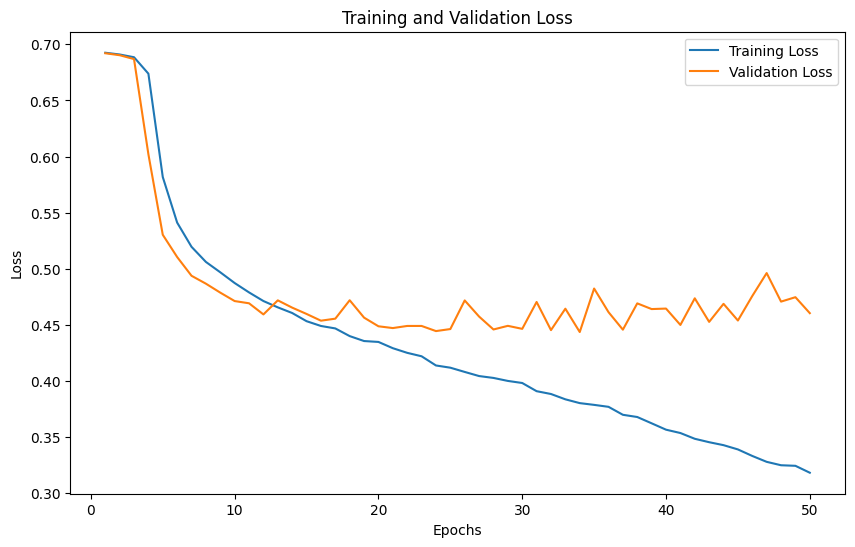

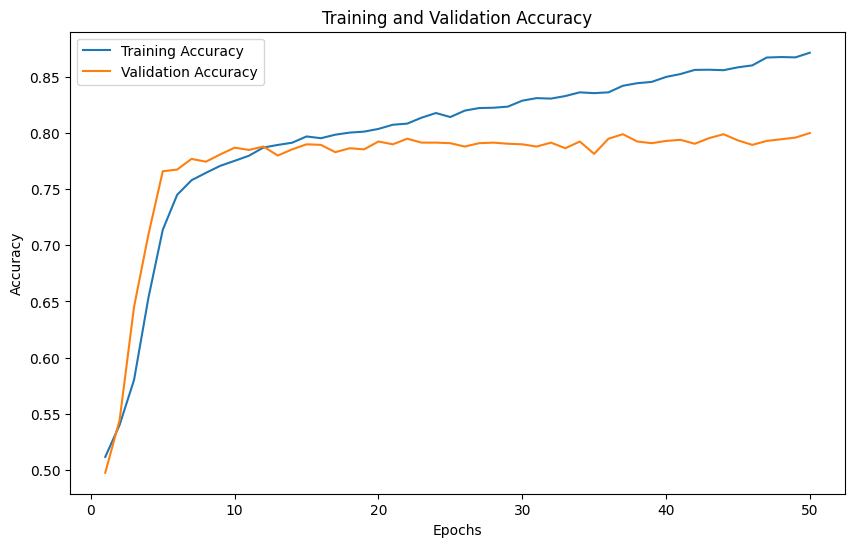

In [ ]:
# Visualize the accuracy and loss change of the best model across training and validation datasets
# Make comments on the results
# Plot training and validation loss
# Plot training and validation loss
def visualize_metrics(metrics, num_epochs):
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), metrics["train_losses"], label='Training Loss')
    plt.plot(range(1, num_epochs + 1), metrics["val_losses"], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), metrics["train_accuracies"], label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1), metrics["val_accuracies"], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

visualize_metrics(custom_metrics, epochs)


The slight difference between training and validation accuracy shows the model has not significantly overfit the training data, which is a positive outcome.

### 7. Testing and Analysis (15 points)

In [ ]:
# Test the best model on the test set to evaluate its performance.
# Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
# Explain and analyze your findings and results.
# Summarize the performance of the model on the training, validation and test set. Comment on the results.
# Discuss any challenges encountered during training and potential areas for improvement.
# Evaluate on the test set
from sklearn.metrics import precision_score, recall_score, f1_score
def evaluate_model(model, test_loader, device):
    model.eval()
    test_predictions = []
    test_targets = []

    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move to GPU
            predictions = model(x_batch).squeeze(1)
            preds = (predictions > 0.5).float()
            test_predictions.extend(preds.cpu().numpy())
            test_targets.extend(y_batch.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(test_targets, test_predictions)
    precision = precision_score(test_targets, test_predictions)
    recall = recall_score(test_targets, test_predictions)
    f1 = f1_score(test_targets, test_predictions)

    print("Test Set Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

loaded_model = SentimentLSTM(
    vocab_size=len(vocab),  # Replace with your actual vocab_size
    embed_dim=300,     # Embedding dimension
    hidden_size=64,   # Hidden size
    output_size=1,     # Binary classification
    embedding_matrix=embedding_matrix,  # Use the same embedding matrix
    freeze_embeddings=True              # Same as during training
)
loaded_model.to(device)
loaded_model.load_state_dict(torch.load('custom_model.pth', map_location=device))


evaluate_model(loaded_model, test_loader, device)



<ipython-input-59-bf914fac9e6a>:42: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Test Set Performance:
Accuracy: 0.7810
Precision: 0.7946
Recall: 0.7871
F1-Score: 0.7908


The test set performance is satisfactory, with an accuracy of 78.10%, a precision of 79.46%, a recall of 78.71%, and an F1-score of 79.08%. These balanced metrics indicate that the model performs consistently across precision and recall, effectively handling both positive and negative sentiment classifications.

#### Comparison with the Pytorch LSTM model (Optional)

In [ ]:
# Implement sentiment LSTM model using PyTorch's built-in LSTM layer
# (below is just an empty example, you can change it entirely to make it suitable with your implementation)

class PyTorchLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_size, output_size, embedding_matrix):
        super(PyTorchLSTM, self).__init__()

        # Define embedding layer with pre-trained embeddings
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)

        # Use PyTorch's built-in LSTM layer
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(p=0.5)  # Adjusted dropout rate for better regularization

        # Fully connected layer for binary classification
        self.fc = nn.Linear(hidden_size, output_size)

        # Sigmoid activation
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Convert word indices to word vectors
        embedded = self.embedding(x)  # Shape: (batch_size, seq_len, embedding_dim)

        # LSTM processing
        lstm_out, (hidden, cell) = self.lstm(embedded)  # lstm_out: (batch_size, seq_len, hidden_size)
                                                        # hidden: (1, batch_size, hidden_size)

        # Use the last hidden state
        hidden = hidden.squeeze(0)  # Shape: (batch_size, hidden_size)

        # Apply dropout
        hidden = self.dropout(hidden)

        # Fully connected layer
        output = self.fc(hidden)  # Shape: (batch_size, output_size)

        # Pass through the sigmoid
        output = self.sigmoid(output)  # Shape: (batch_size, output_size)

        return output


In [ ]:
# Implement the training loop
# Iterate over the training dataset in mini-batches.
# Implement forward pass, feed the inputs through the network to compute the predictions.
# Validate the model on the validation set periodically to monitor performance

In [ ]:
# Define parameters
# Define criterion and optimizer
# Train PyTorch LSTM model
model = PyTorchLSTM(embedding_dim=300, hidden_size=16, output_size=1, embedding_matrix=embedding_matrix)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-4)  # Added weight decay for regularization

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Train the mode
built_in_metrics = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs, 'built_in_model.pth')

Epoch 1/50
  Train Loss: 0.6940, Accuracy: 50.59%
  Validation Loss: 0.6917, Accuracy: 54.80%
Epoch 2/50
  Train Loss: 0.6916, Accuracy: 52.24%
  Validation Loss: 0.6893, Accuracy: 58.90%
Epoch 3/50
  Train Loss: 0.6762, Accuracy: 58.96%
  Validation Loss: 0.6426, Accuracy: 65.40%
Epoch 4/50
  Train Loss: 0.6037, Accuracy: 71.34%
  Validation Loss: 0.5566, Accuracy: 76.05%
Epoch 5/50
  Train Loss: 0.5648, Accuracy: 74.29%
  Validation Loss: 0.5289, Accuracy: 76.10%
Epoch 6/50
  Train Loss: 0.5385, Accuracy: 75.73%
  Validation Loss: 0.5351, Accuracy: 76.45%
Epoch 7/50
  Train Loss: 0.5244, Accuracy: 76.07%
  Validation Loss: 0.5031, Accuracy: 76.95%
Epoch 8/50
  Train Loss: 0.5063, Accuracy: 77.33%
  Validation Loss: 0.4959, Accuracy: 76.80%
Epoch 9/50
  Train Loss: 0.4997, Accuracy: 77.47%
  Validation Loss: 0.4876, Accuracy: 77.25%
Epoch 10/50
  Train Loss: 0.4843, Accuracy: 78.83%
  Validation Loss: 0.4784, Accuracy: 78.05%
Epoch 11/50
  Train Loss: 0.4677, Accuracy: 79.84%
  Valida

In [ ]:
loaded_model2 = PyTorchLSTM(
    embedding_dim=300,  # Same embedding dimension used during training
    hidden_size=16,     # Same hidden size
    output_size=1,      # Binary classification
    embedding_matrix=embedding_matrix  # Use the same embedding matrix
)

loaded_model2.to(device)

loaded_model2.load_state_dict(torch.load('built_in_model.pth', map_location=device))


evaluate_model(loaded_model2, test_loader, device)


<ipython-input-79-620c0411a3cc>:10: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Test Set Performance:
Accuracy: 0.8070
Precision: 0.8101
Recall: 0.8270
F1-Score: 0.8184


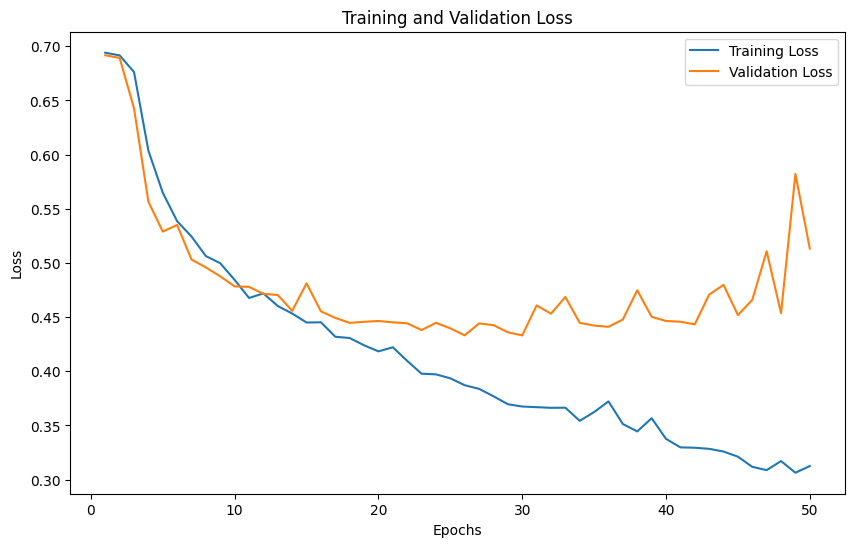

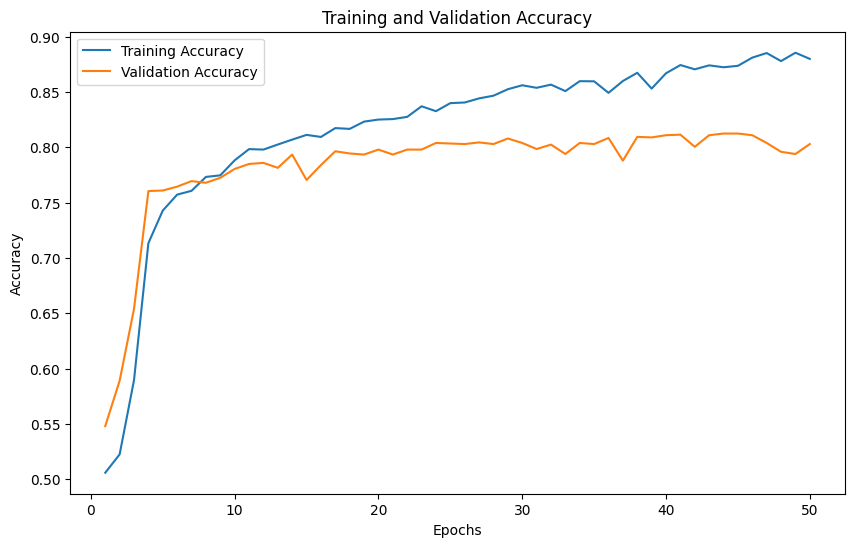

In [ ]:
# Compare the performance of your custom LSTM model with PyTorchLSTM model
visualize_metrics(built_in_metrics, epochs)

The model with PyTorch’s nn.LSTM layer achieved better overall performance, with a training accuracy of 88.56% and a validation accuracy of 81.25%. It also performed better on the test set, with an accuracy of 80.70% and an F1-score of 81.84%. In comparison, my custom LSTM model reached a training accuracy of 87.16%, a validation accuracy of 80.00%, and test set metrics of 78.10% accuracy and 79.08% F1-score. The PyTorch nn.LSTM model likely performed better due to its highly optimized implementation, which is faster and more accurate at handling sequential data. My custom LSTM model, while slightly less efficient, still demonstrated strong learning capability and **achieved stable results**. **One key observation is that my custom model maintained a good balance between training and validation metrics**, showing minimal overfitting. In contrast, the nn.LSTM model exhibited slight overfitting in later epochs, as validation loss started increasing while training loss continued to decrease.

Training my custom LSTM model presented several challenges. One significant difficulty was correctly implementing the LSTM cell, particularly ensuring the proper functioning of the gating mechanisms (forget, input, and output gates) and their interactions with the cell and hidden states. Another challenge was achieving efficient training, as my custom implementation lacked the optimization of PyTorch's built-in nn.LSTM layer, resulting in longer training times.

While the model demonstrated reasonable accuracy and stability, its performance fell slightly short of that achieved with the nn.LSTM layer. This highlights areas for improvement, such as fine-tuning hyperparameters like the learning rate, batch size, and weight decay. Additionally, exploring more effective methods for handling out-of-vocabulary (OOV) words and experimenting with alternative embedding strategies could further enhance the model’s learning and generalization capabilities.

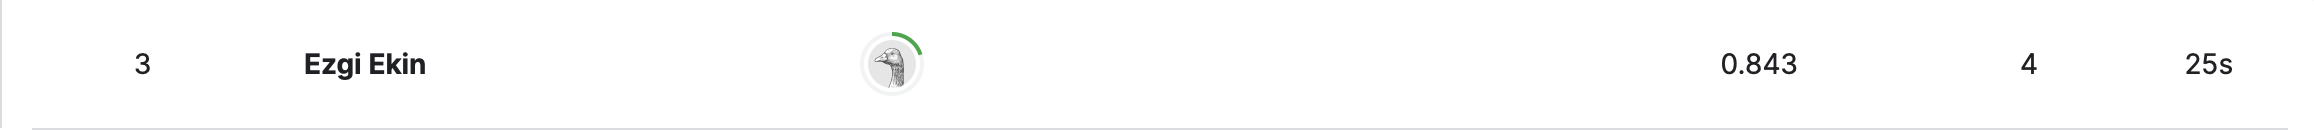